In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Importing

In [3]:
names = ['sig_m350GeV', 'sig_m1TeV', 'bg']
data = [np.load('data/' + name + '.npy') for name in names]
sig350G, sig1T, bg = data

In [4]:
print(bg.shape)

(3000000, 9)


In [5]:
# each element of "data" is 2D numpy array of dimension N x 9, where the 9 columns correspond to the kinematic 
# variables specified here
cols = ['$p_T(b_1)$', '$p_T(b_2)$', '$p_T(j_1)$', '$p_T(j_2)$', '$\Delta R(b_1, b_2)$', '$\Delta R(j_1, j_2)$',
       'm_{b_1 b_2}', 'MET', 'merged status']

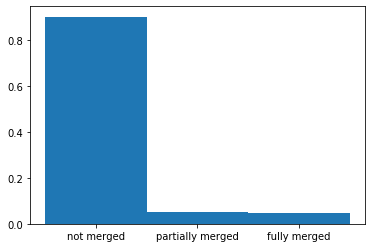

In [6]:
plt.hist(bg[:,-1], weights=np.ones_like(bg[:,-1])/len(bg), bins=[-0.5, 0.5, 1.5, 2.5]);
plt.xticks([0,1,2],['not merged', 'partially merged', 'fully merged']);

# Signal Significance

In [7]:
alldata = np.concatenate((sig350G, sig1T, bg))
print(alldata.shape)

(5000000, 9)


In [8]:
samples = [] # becomes 9 x 10 array where ith row contains cut values evenly space between max and min for ith kinematic variable
significance = [] # becomes 9 x 10 array where ith row contains significance values for 10 cut values
r = 0.25
for i, col in enumerate(cols): # iterate over kinematic variables
    maxval, minval = [np.max(alldata[:,i]), np.min(alldata[:,i])] # largest/smallest value attained for kin. var.
    samples.append(np.linspace(minval, maxval, 10)) # sampling evenly between largest and smallest
    sig1signif, sig2signif = [[], []] 
    for val in samples[-1]: 
        nums = [np.count_nonzero(elem[:,i] > val) for elem in data] # number of events surviving selection
        sig1signif.append(nums[0] / np.sqrt(nums[0] + nums[2] + r * (nums[0] + nums[2])**2 + 1)) # sig. significance (350 GeV)
        sig2signif.append(nums[1] / np.sqrt(nums[1] + nums[2] + r * (nums[0] + nums[2])**2 + 1)) # sig. significance (1 TeV)
    significance.append([sig1signif, sig2signif])

In [9]:
# interpolation function for 1D data
import scipy.interpolate

def interpolate(x, y, label='line'):
    pts = np.linspace(x[0], x[-1], 1000)
    f = scipy.interpolate.interp1d(x, y, kind='cubic')
    interp = [f(pt) for pt in pts]
    return[pts, interp]

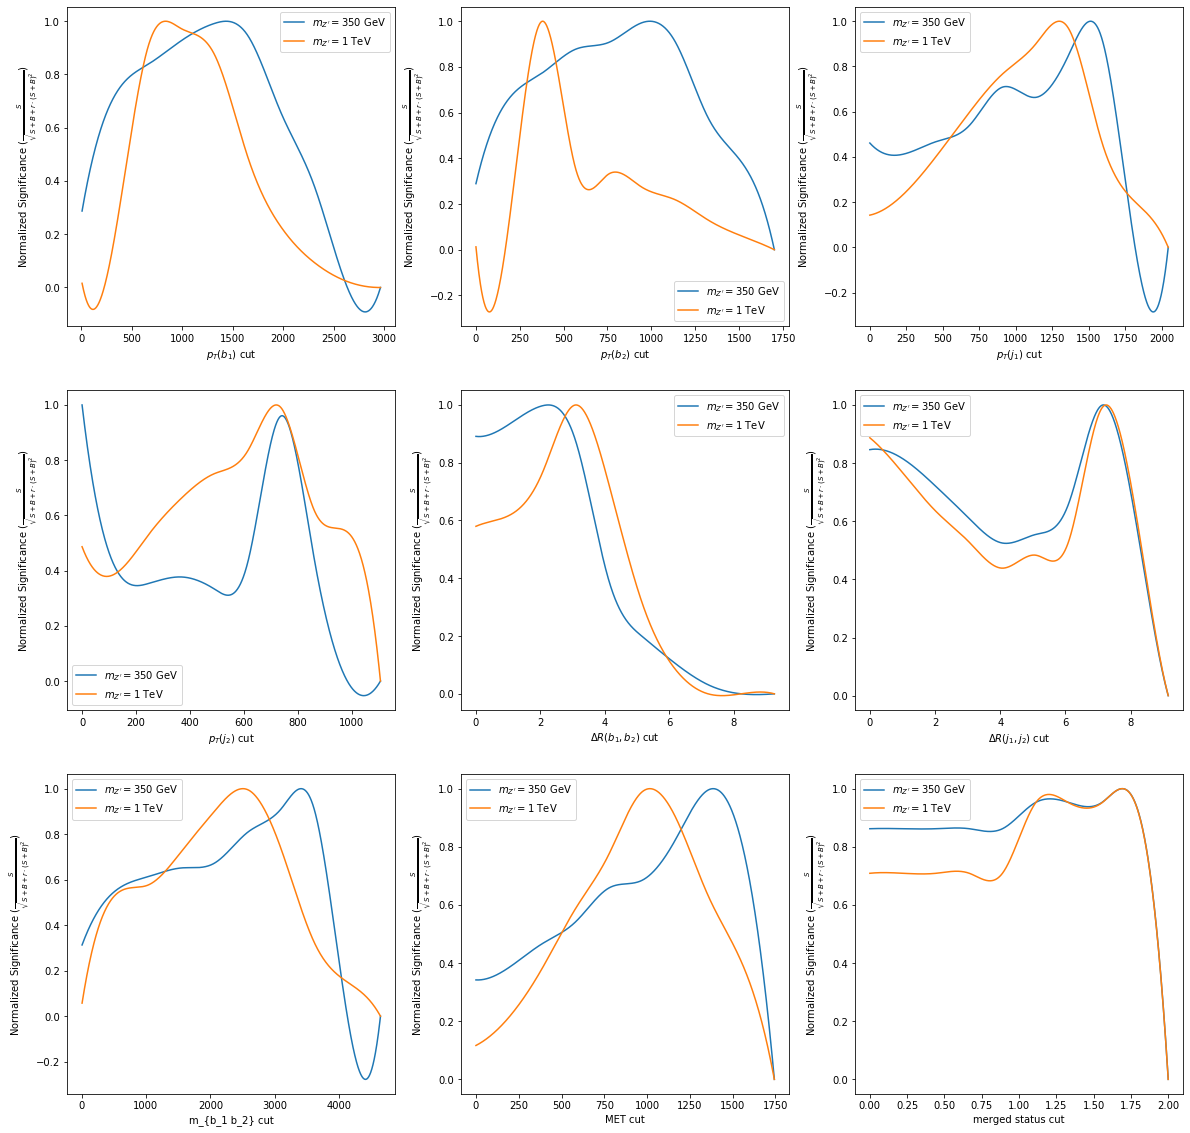

In [10]:
# plotting normalized significance as a function of selection 
with plt.rc_context({'figure.figsize': (20,20)}):
    for i, (samp, sig) in enumerate(zip(samples, significance)):
        plt.subplot(3,3,i+1)
        sig1_x, sig1_y = interpolate(samp, sig[0])
        sig2_x, sig2_y = interpolate(samp, sig[1])
        plt.plot(sig1_x, sig1_y/max(sig1_y), label=r"$m_{Z'} = 350$ GeV")
        plt.plot(sig2_x, sig2_y/max(sig2_y), label=r"$m_{Z'} = 1$ TeV")
        plt.xlabel(r'{} cut'.format(cols[i]))
        plt.ylabel(r'Normalized Significance ($\frac{S}{\sqrt{S+B+r\cdot(S+B)^2}}$)')
        plt.legend()

# ML

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
# standardize data to have mean = 0, std = 1
sig1, sig2, bg = [(elem - np.mean(elem, axis=0)) / np.std(elem, axis=0) for elem in data]

In [13]:
# build the NN
inputs = keras.Input(shape=(9,))
layer1 = layers.Dense(20)(inputs)
layer2 = layers.Dense(20)(layer1)
outputs = layers.Dense(1, activation='softmax')(layer2)
model = keras.Model(inputs=inputs, outputs=outputs, name='sig_bg_bin_class')
model.summary()

Model: "sig_bg_bin_class"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


In [14]:
# compile the model
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=["accuracy"],
)

In [15]:
# plucking out data to train with
sig1train = sig1[:500000]
sig2train = sig2[:500000]
bgtrain = np.concatenate((bg[:500000], bg[1000000:1500000], bg[2000000:2500000]))
# print(sig1train.shape, sig2train.shape, bgtrain.shape)

In [16]:
# assembling predictors/labels
train1predictors = np.concatenate((sig1train, bgtrain))
train1labels = np.concatenate((np.ones((len(sig1train),)), np.zeros((len(bgtrain),))))

In [17]:
# shuffling data to enable taking small pieces
train1labels = train1labels.reshape((len(train1labels),1))
train1 = np.concatenate((train1predictors, train1labels), axis=1)
np.random.shuffle(train1)
# np.save('train1', train1)

In [18]:
train = np.load('data/train1.npy')
train_pred = train[:,:-1]
train_label = train[:,-1]

In [ ]:
# this crashes jupyter?
history = model.fit(train_pred[:10000], train_label[:10000].reshape((10000,1)), batch_size=20, epochs=10, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10


In [ ]:
# test_scores = model.evaluate(x_test, y_test, verbose=2)
# print("Test loss:", test_scores[0])
# print("Test accuracy:", test_scores[1])